# Experiment 1: Pre-Processing Techniques
In this series of experiments, we will investigate the effects of oversampling and undersampling the classes in our dataset.

## Investigating the dataset

Loading imports

In [ ]:
%pip install datasets
import nltk
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset, load_metric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00


Loading the dataset

In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

What is the majority class in the dataset?

In [ ]:
# First, we will flatten our BIO labels to make it easier for counting
flatTrainLabels = [item for sublist in train_dataset["ner_tags"] for item in sublist]

# print(flatTrainLabels)

# Count the occurences of each label in our list
majorityClass = max(flatTrainLabels, key = flatTrainLabels.count)

print(majorityClass) # Our majority class is B-O

B-O


How big is our class imbalance?

In [ ]:
BOCount = flatTrainLabels.count('B-O')
BLFCount = flatTrainLabels.count('B-LF')
BACCount = flatTrainLabels.count('B-AC')
ILFCount = flatTrainLabels.count('I-LF')

print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

# We have a massive class imbalance of over 30000 items to B-O!

Amount of B-O: 32971
Amount of B-LF: 1462
Amount of B-AC: 2336
Amount of I-LF: 3231


## Experiment 1.1: Undersampling the Dataset
Lets see what happens when we try to undersample the majority class from our dataset.

In [ ]:
# We get our flattened list of tokens so it is again easier to work with

flatTrainTokens = [item for sublist in train_dataset["tokens"] for item in sublist]

# Fetching our test set of tokens and tags for later

flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]

# We need to make sure that the amount of tokens and labels are the same so we can undersample using indices!
print(len(flatTrainTokens))
print(len(flatTrainLabels))

40000
40000


Creating a function to undersample the dataset

In [ ]:
import random

random.seed(27) # Set a seed for reproducibility

'''
Function to undersample a dataset in the form of two seperate flattened 1D arrays

Inputs:
tokenList: flattened 1D array containing a list of tokens
tagList: flattened 1D array containing a list of tags
undersampleClass: Tag class that we want to undersample
probability: probability of choosing a given item and sampling it

Outputs:
newTokens: flattened 1D array containing the undersampled set of tokens
newTags: flattened 1D array containing the undersampled set of tags


'''
def undersampleFlatDataset(tokenList, tagList, undersampleClass, probability):
  newTokens = []
  newTags = []

  # Iterate through each token and tag
  for token, tag in zip(tokenList, tagList):
    # We do a dice roll if we hit a class that we want to undersample
    if tag == undersampleClass:
      # If the dice roll is less than our defined probability then we add it to the list
      if random.random() < probability:
        newTokens.append(token)
        newTags.append(tag)
    # We just add it back to the list if it is not a undersample class
    else:
      newTokens.append(token)
      newTags.append(tag)

  return newTokens, newTags

Getting our undersampled data

In [ ]:
underTokens, underTags = undersampleFlatDataset(flatTrainTokens, flatTrainLabels, 'B-O', 0.3)

Checking our new data (and sanity checks)

In [ ]:
print(len(underTokens))
print(len(underTags))

# We have significantly reduced the amount of data to train with by choosing a lower probability for undersampling

BOCount = underTags.count('B-O')
BLFCount = underTags.count('B-LF')
BACCount = underTags.count('B-AC')
ILFCount = underTags.count('I-LF')

print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

16710
16710
Amount of B-O: 9681
Amount of B-LF: 1462
Amount of B-AC: 2336
Amount of I-LF: 3231


Next, we will test this data using an SVM and the TFIDF vectoriser

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(underTokens)
valInputs = tfidf.transform(flat_inputs_val)

# Confirm both sets of inputs are of the same dimension
print(trainInputs.shape)
print(valInputs.shape)

(16710, 5275)
(5000, 5275)


Converting our tags to numeric data so it can be used with the SVM

In [ ]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in underTags:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

16710
5000


Training and predicting with the SVM

In [ ]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

from sklearn.metrics import classification_report

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

# We can see that each class other than 0 gets a small boost to the F1 Score compared to without undersample

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4261
           1       0.81      0.43      0.56       263
           2       0.40      0.41      0.40       149
           3       0.37      0.43      0.39       327

    accuracy                           0.85      5000
   macro avg       0.62      0.55      0.57      5000
weighted avg       0.85      0.85      0.85      5000



Getting a confusion matrix

[[3935   23   78  225]
 [ 148  113    0    2]
 [  73    3   61   12]
 [ 173    0   15  139]]


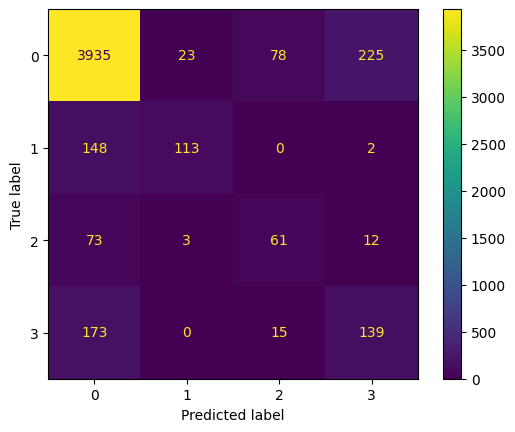

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

## Experiment 1.2: Oversampling the dataset

Let's see what happens to our scores when we try to oversample the minority classes from our dataset.

In [ ]:
# Regenerate the dataset
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

flatTrainTokens = [item for sublist in train_dataset["tokens"] for item in sublist]
flatTrainLabels = [item for sublist in train_dataset["ner_tags"] for item in sublist]

flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]

One simple way we can artificially oversample minority classes of our dataset is by duplicating their entries at random. We will later see however that using such a crude method may not be as beneficial as we think.

In [ ]:
import random

random.seed(27) # Fix the seed for reproducibility

'''
Function to undersample a dataset in the form of two seperate flattened 1D arrays

Inputs:
tokenList: flattened 1D array containing a list of tokens
tagList: flattened 1D array containing a list of tags
undersampleClass: Tag class that we want to oversample
probability: probability of choosing a given item and sampling it, higher == more of a chance to duplicate the item
epochs: number of times to run oversampling for the given class over the dataset, set to 1

Outputs:
newTokens: flattened 1D array containing the oversampled set of tokens
newTags: flattened 1D array containing the oversampled set of tags


'''

# In theory we can at maximum only double our minority classes, but we can re-run the function
def oversampleFlatDataset(tokenList, tagList, oversampleClass, probability, epochs = 1):
  newTokens = []
  newTags = []

  for epoch in range(epochs):
    # Iterate through the tags and tokens
    for token, tag in zip(tokenList, tagList):

      if tag == oversampleClass:
        # Dice roll to see if we duplicate the item
        if random.random() < probability:
          # We duplicate the tokens and the tags
          newTokens.append(token)
          newTokens.append(token)

          newTags.append(tag)
          newTags.append(tag)

      # If its not the target class we add it back normally
      else:
        newTokens.append(token)
        newTags.append(tag)

  return newTokens, newTags

We can chain the function together to oversample multiple classes

In [ ]:
oversampleTrainTokens, oversampleTrainLabels = oversampleFlatDataset(flatTrainTokens, flatTrainLabels, 'B-LF', 0.7)

oversampleTrainTokens, oversampleTrainLabels = oversampleFlatDataset(oversampleTrainTokens, oversampleTrainLabels, 'B-AC', 0.7)

oversampleTrainTokens, oversampleTrainLabels = oversampleFlatDataset(oversampleTrainTokens, oversampleTrainLabels, 'I-LF', 0.7)

Checking our label counts again (and sanity checking)

In [ ]:
print(len(oversampleTrainTokens))
print(len(oversampleTrainLabels))

dataset2Count = oversampleTrainLabels

# We have significantly reduced the amount of data to train with by choosing a lower probability for undersampling

BOCount = dataset2Count.count('B-O')
BLFCount = dataset2Count.count('B-LF')
BACCount = dataset2Count.count('B-AC')
ILFCount = dataset2Count.count('I-LF')

# We can see that we have artificially boosted the amount of data we have for our minority classes
print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

42727
42727
Amount of B-O: 32971
Amount of B-LF: 1960
Amount of B-AC: 3222
Amount of I-LF: 4574


Lets try training the SVM again with the oversampled dataset

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(oversampleTrainTokens)
valInputs = tfidf.transform(flat_inputs_val)

# Confirm both sets of inputs are of the same dimension
print(trainInputs.shape)
print(valInputs.shape)

(42727, 7341)
(5000, 7341)


In [ ]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in oversampleTrainLabels:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

42727
5000


In [ ]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

from sklearn.metrics import classification_report

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

# We can see that the crude duplication of items tends to negatively affect the SVM

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      4261
           1       0.82      0.36      0.50       263
           2       0.52      0.32      0.40       149
           3       0.43      0.28      0.34       327

    accuracy                           0.87      5000
   macro avg       0.67      0.48      0.54      5000
weighted avg       0.85      0.87      0.85      5000



Getting the Confusion Matrix. Observing the classification report, as result of oversampling, we get worse results when it comes to the minority classes. Therefore, we need a smarter way to oversample the data rather than just duplicating it.

[[4094   18   37  112]
 [ 167   95    0    1]
 [  91    3   48    7]
 [ 227    0    8   92]]


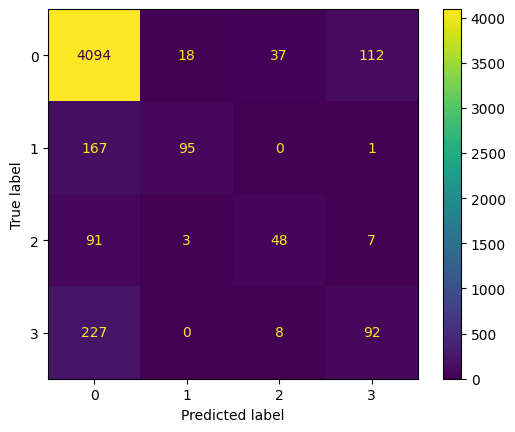

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

## Experiment 1.3: Combining both undersampling and oversampling methods
We know that undersampling improves performance and crudly oversampling hurts performance. What happens if we use both methods?

In [ ]:
# Regenerating datasets
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Flattening the datasets
flatTrainTokens = [item for sublist in train_dataset["tokens"] for item in sublist]
flatTrainLabels = [item for sublist in train_dataset["ner_tags"] for item in sublist]

flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]

Functions for undersampling and oversampling

In [ ]:
import random

random.seed(27) # Reproducibility

# Function to undersample a dataset in the form of two seperate flattened 1D arrays
def undersampleFlatDataset(tokenList, tagList, undersampleClass, probability):
  newTokens = []
  newTags = []

  # Iterate through each token and tag
  for token, tag in zip(tokenList, tagList):
    # We do a dice roll if we hit a class that we want to undersample
    if tag == undersampleClass:
      # If the dice roll is less than our defined probability then we add it to the list
      if random.random() < probability:
        newTokens.append(token)
        newTags.append(tag)
    # We just add it back to the list if it is not a undersample class
    else:
      newTokens.append(token)
      newTags.append(tag)

  return newTokens, newTags


# In theory we can at maximum only double our minority classes, but we can re-run the function
def oversampleFlatDataset(tokenList, tagList, oversampleClass, probability, epochs = 1):
  newTokens = []
  newTags = []

  for epoch in range(epochs):
    # Iterate through the tags and tokens
    for token, tag in zip(tokenList, tagList):

      if tag == oversampleClass:
        # Dice roll to see if we duplicate the item
        if random.random() < probability:
          # We duplicate the tokens and the tags
          newTokens.append(token)
          newTokens.append(token)

          newTags.append(tag)
          newTags.append(tag)

      # If its not the target class we add it back normally
      else:
        newTokens.append(token)
        newTags.append(tag)

  return newTokens, newTags

Running undersampling on the data first, then we oversample the minority classes

In [ ]:
underTokens, underTags = undersampleFlatDataset(flatTrainTokens, flatTrainLabels, 'B-O', 0.3)

# We reduce the duplication probability as it is important to balance the oversampling if we are using this method
resampledTokens, resampledTags = oversampleFlatDataset(underTokens, underTags, 'B-LF', 0.4)
resampledTokens, resampledTags = oversampleFlatDataset(resampledTokens, resampledTags, 'B-AC', 0.4)
resampledTokens, resampledTags = oversampleFlatDataset(resampledTokens, resampledTags, 'I-LF', 0.4)

Checking the quantities of our resampled data

We are looking a for reduced number of B-O with a slight increase to our minority classes

In [ ]:
data2count = resampledTags

BOCount = data2count.count('B-O')
BLFCount = data2count.count('B-LF')
BACCount = data2count.count('B-AC')
ILFCount = data2count.count('I-LF')

print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

Amount of B-O: 9979
Amount of B-LF: 1146
Amount of B-AC: 1764
Amount of I-LF: 2608


Embedding the tokens with TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(resampledTokens)
valInputs = tfidf.transform(flat_inputs_val)

# Confirm both sets of inputs are of the same dimension
print(trainInputs.shape)
print(valInputs.shape)

(15497, 3914)
(5000, 3914)


Converting the labels to numeric

In [ ]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in resampledTags:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

15497
5000


Training and evaluating the SVM

In [ ]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

from sklearn.metrics import classification_report

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4261
           1       0.67      0.24      0.35       263
           2       0.35      0.30      0.32       149
           3       0.35      0.32      0.34       327

    accuracy                           0.84      5000
   macro avg       0.56      0.45      0.48      5000
weighted avg       0.83      0.84      0.83      5000



We see that crude oversampling causes the most harm to training the SVM while undersampling does provide a decent boost to the minority scores.

[[3987   28   72  174]
 [ 200   62    0    1]
 [  87    3   45   14]
 [ 211    0   12  104]]


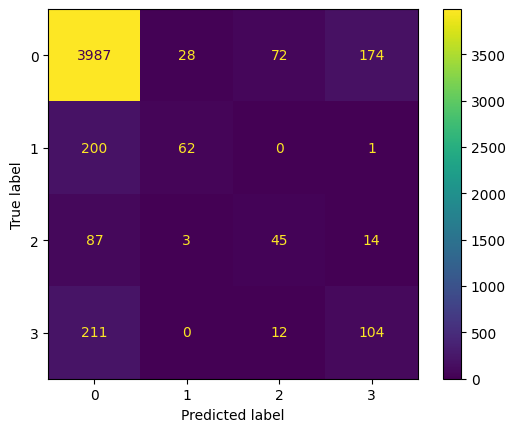

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

# Experiment 2: Investigating Different NLP Algorithms
In this series of experiments, we will investigate the performance of an HMM model and the DistilBERT on the reduced dataset.

## Experiment 2.1: Investigating Hidden Markov Models (HMM)

Loading required imports for the experiments

In [ ]:
%pip install datasets
import nltk
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset, load_metric

Retrieving the dataset from HuggingFace

In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

First we need the set of sentences and tags inside our dataset

In [ ]:
# We grab the sentences in this format as it gives us an easier list format to work with
trainSentences = dataset["train"][:]["tokens"]
trainLabels = dataset["train"][:]["ner_tags"]

print(len(trainSentences))

print(trainSentences)
print(trainLabels)

1072
[['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.'], ['The', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'gs', ',', 'mol', 'H2O', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'E', ',', 'mmol', 'H2O', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'PN', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'CO2', 'concentration', 'CO2', '(', 'Ci', ',', 'μmol', 'm-2', 's-1', ')', '.'], ['Minor', 'H', 'antigen', 'alloimmune', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'HLA)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'SCT', ')', '[', '3,4', ']', '.'], ['EPI', '=', 'Echo', 'planar', 'imaging', '.'], ['Furthermore', ',', 'eNOS', '-', 'derived', 'NO', 'S', '-', 'nitrosylated', 'β', '-', 'actin', 'on', 'Cys374', 'and', 'impai

For an HMM to work, we need the unique set of tokens in our dataset, split by their characters to act as our set of symbols. We also need the unique set of states or labels that our symbols can be in.

In [ ]:
# We need the unique set of tokens
# We need the unique set of labels (pre-post conversion?)

symbolSet = set()
for tokenSet in trainSentences:
  for token in tokenSet:
    for char in token:
      symbolSet.add(char)

# Get the unique set of labels
entitySet = set()
for tagSet in trainLabels:
  for tag in tagSet:
    entitySet.add(tag)

HMM needs our data in lists so we convert our sets to lists (also sanity checking)

In [ ]:
entitySet = list(entitySet) # Convert back to lists
print(entitySet)

symbolSet = list(symbolSet)
print(symbolSet)
print(len(symbolSet))

['B-AC', 'I-LF', 'B-O', 'B-LF']
['F', 'g', 'c', 'a', '°', '=', '-', 'Q', '•', 'R', ']', '∑', 'f', '≥', 'Ω', 'y', 'Y', 'J', 'σ', '?', 'ã', '）', 'ü', 'o', '4', 'r', 'w', 'X', '_', 'Å', '¯', ')', 'Ä', '1', 'm', '*', 'ε', 'd', '7', '·', '‒', '´', '5', 'λ', 'u', 'j', '±', 'N', 'L', 'μ', 'H', 'I', 'l', 'n', 'z', 'µ', 'è', '♂', '‘', 'S', '%', 'V', 'ν', 'α', 'θ', "'", '†', '#', 'E', 'v', 'x', 's', 'Z', '&', '…', '∞', 'B', '0', 'e', '3', '’', 'C', '$', 'é', '+', '@', 'O', '2', '®', 'h', '≤', '‡', 'β', '[', '9', 'ó', ';', '§', '.', '"', 'k', 'ï', ':', '8', 'G', 'ß', 'δ', 'M', 'T', 'ö', 'b', '<', 'A', '′', '→', 'í', '（', 'γ', '×', 'W', '{', '–', '“', ',', '6', 'q', 'Δ', '—', 'P', '”', 'κ', '/', '♀', 'D', 't', 'K', 'ú', 'Φ', '}', '(', 'i', 'p', 'U', '>', '−']
145


Flattening training data for potential use later

In [ ]:
# Flatten the training data for easy use later
flat_inputs_train = [item for sublist in train_dataset["tokens"] for item in sublist]
flat_labels_train = [item for sublist in train_dataset["ner_tags"] for item in sublist]

We need to go through our training sentences and convert them into a flat dataset with pairings of the token and the state/tag in the form of a tuple. We can do this with list comprehension (or double list comprehension)

In [ ]:
# Double list comprehension
trainCombinedOld = [[(token, label) for token, label in zip(tokenSet, labelSet)] for tokenSet, labelSet in zip(trainSentences, trainLabels)]

# Single list comprehension
trainCombined = []
for tokens, labels in zip(trainSentences, trainLabels):
    sequence = [(token, label) for token, label in zip(tokens, labels)]
    trainCombined.append(sequence)

print(trainCombined[0])
print(trainCombinedOld[0])

# Note that it is very very very important that this is done correctly or the HMM will have errors when evaluating!

[('For', 'B-O'), ('this', 'B-O'), ('purpose', 'B-O'), ('the', 'B-O'), ('Gothenburg', 'B-LF'), ('Young', 'I-LF'), ('Persons', 'I-LF'), ('Empowerment', 'I-LF'), ('Scale', 'I-LF'), ('(', 'B-O'), ('GYPES', 'B-AC'), (')', 'B-O'), ('was', 'B-O'), ('developed', 'B-O'), ('.', 'B-O')]
[('For', 'B-O'), ('this', 'B-O'), ('purpose', 'B-O'), ('the', 'B-O'), ('Gothenburg', 'B-LF'), ('Young', 'I-LF'), ('Persons', 'I-LF'), ('Empowerment', 'I-LF'), ('Scale', 'I-LF'), ('(', 'B-O'), ('GYPES', 'B-AC'), (')', 'B-O'), ('was', 'B-O'), ('developed', 'B-O'), ('.', 'B-O')]


Setting up and training the HMM

We just need to declare our sets of symbols and states and then pass our training data to the model.

In [ ]:
trainerSetup = nltk.tag.hmm.HiddenMarkovModelTrainer(states = entitySet, symbols = symbolSet)

model = trainerSetup.train_supervised(trainCombined)

Evaluating with the HMM that we trained

In [ ]:
import numpy as np

val_sentences = dataset["validation"][:]["tokens"] # Fetch from our validation set

# Getting the flattened tags for validation set
flatValLabels = [item for sublist in val_dataset["ner_tags"] for item in sublist]

# We need to individually go through each token in our dataset,
# evaluate on them using the HMM, then we extract the tag that comes out from the model
predicted = []
for sentence in val_sentences:
    val_result = model.tag(sentence)
    out_tags = []
    for word, tag in val_result:
        out_tags.append(tag)
    predicted.append(out_tags)

Flatten out our list of predicted tags

In [ ]:
predTags = [tag for tagList in predicted for tag in tagList]

print(predTags)

print(len(predTags))

print(set(predTags)) # Make sure that all tags exist

['B-O', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 

Getting the classification report for the HMM

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(flatValLabels, predTags))

              precision    recall  f1-score   support

        B-AC       0.06      0.97      0.11       263
        B-LF       0.64      0.12      0.20       149
         B-O       0.95      0.12      0.21      4261
        I-LF       0.73      0.11      0.19       327

    accuracy                           0.16      5000
   macro avg       0.60      0.33      0.18      5000
weighted avg       0.88      0.16      0.20      5000



Observing the classification report, we can see that with the limited dataset, the HMM performs poorly as it is a probability based model which is greatly affected by the class imbalance seen by the B-O tags

[[ 254    1    8    0]
 [ 126   18    5    0]
 [3732    9  507   13]
 [ 278    0   13   36]]


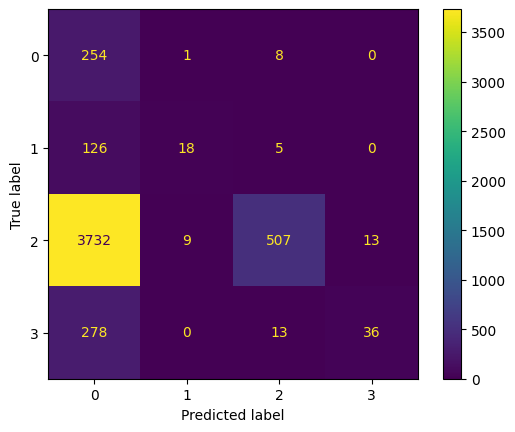

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(flatValLabels, predTags)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

## Experiment 2.2: Investigating DistilBERT (Code mostly reused from the labs)

Note: We need a GPU for this (or wait 45 minutes to train)

Loading Dependencies

In [1]:
# Install the necessary dependencies
%pip install datasets
%pip install transformers
%pip install spacy
%pip install torch
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

Loading dataset from HuggingFace

In [2]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW") # Working with the reduced dataset

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

Next, we need to setup up the tokeniser and model from HuggingFace. As we are using a pretrained DistilBERT model, we are required to use the tokeniser that was trained with it

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Simple change, just get the DistilBERT model weights and tokeniser from HuggingFace
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=4) # 4 Labels in the reduced dataset

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT requires the labels in a numeric format rather than alphabetic, so we convert our labels first

In [4]:
# Convert Labels to numeric for BERT

label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

label_list = []
for sample in train_dataset["ner_tags"]:
    label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in val_dataset["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in test_dataset["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])

When we use a BERT model or it's variants, when we send an input to its tokeniser, a CLS and SEP token are added. This is for use with the attention aspect of its transformer. As they add these two special tokens, we need to realign our tag indices correctly so they once again match up

In [5]:
def tokenize_and_align_labels(train_dataset, list_name):
    tokenized_inputs = tokenizer(train_dataset["tokens"], truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Tokenise and realign the datasets

In [6]:
tokenized_datasets = tokenize_and_align_labels(train_dataset, label_list)
tokenized_val_datasets = tokenize_and_align_labels(val_dataset, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_dataset, test_label_list)

We need to convert the dataset back to a list of dictionaries so DistilBERT can understand it during training

In [7]:
# BERT's tokenizer returns the dataset in the form of a dictionary of lists (sentences).
# we have to convert it into a list of dictionaries for training.
def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list

In [8]:
tokenised_train = turn_dict_to_list_of_dict(tokenized_datasets)
tokenised_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenised_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

To speed up training, we can setup our dataset to be in batches, which will greatly improve performance as we can work on multiple things at once with a GPU. We use the datacollater function to do this

In [9]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

Next we need to set up our metrics that we will use to evaluate the model's performance

In [10]:
import numpy as np

metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

<ipython-input-10-7c72ccf86762>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


We now setup our hyperparameters for DistilBERT

In [11]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Training arguments (feel free to play around with these values)
model_name = "distilbert-base-uncased'"
epochs = 6 # Run through the dataset 6 times
batch_size = 8 # Increase if we have the VRAM available to do so, speeding up training
learning_rate = 2e-5 # Obvious

args = TrainingArguments(
    f"distilBERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000, # How many tokens do we run evaluation for?
    save_total_limit = 3, # Reduce this number to stop the disk space from filling up over time
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001, # Reduces the learning rate over time
    save_steps=35000, # At what step do we want to checkpoint the model
    metric_for_best_model = 'f1', # How do we measure what model is the best?
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


When we are ready, we can start training. Remember that the bigger the dataset, the longer training will take. Very important that if we were to work with bigger datasets we are basically required to have a GPU. As this experiment uses the smaller dataset, we could sit through 45 minutes of CPU training if we dont have a GPU available

In [12]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=804, training_loss=0.22286927996583245, metrics={'train_runtime': 71.92, 'train_samples_per_second': 89.433, 'train_steps_per_second': 11.179, 'total_flos': 170479879923072.0, 'train_loss': 0.22286927996583245, 'epoch': 6.0})

Decode our predictions and labels given the test dataset

In [13]:
# Prepare the test data for evaluation in the same format as the training data

predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2) # We select the predictions with the highest probability

# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test restuls
results = metric.compute(predictions=true_predictions, references=true_labels)
results

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [1, 0, 2, 3, 3, 0] seems not to be NE tag.
  warnings.warn('{} seems not t

{'0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]': {'precision': 0.6688963210702341,
  'recall': 0.7490636704119851,
  'f1': 0.7067137809187279,
  'number': 267},
 '0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0]': {'precision': 0.6296928327645052,
  'recall': 0.6884328358208955,
  'f1': 0.6577540106951872,
  'number': 536},
 '0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0]': {'precision': 0.6566265060240963,
  'recall': 0.7315436241610739,
  'f1': 0.692063492063492,
  'number': 149},
 '1, 0, 2, 3, 3, 0]': {'precision': 0.6462585034013606,
  'recall': 0.7364341085271318,
  'f1': 0.6884057971014493,
  'number': 129},
 'overall_precision': 0.6452420701168614,
 'overall_recall': 0.7150786308973173,
 'overall_f1': 0.6783677051338306,
 'overall_accuracy': 0.9233198015336039}

Note to self, add confusion matrix!!

We can see that utilising a model capable of LSTM in the sense of a transformer, we can greatly improve performance and accuracy.

# Experiment 3: Investigating Text Encoding / Vectorisation Methods
In this series of experiments, we will investigate the differences in performance when encoding text with three different algorithms. Word2Vec, TFIDF and GLoVE. We will use an SVM for evaluation and training.

## Experiment 3.1: Investigating Word2Vec

Loading imports needed

In [ ]:
# Install the necessary dependencies
%pip install datasets
%pip install transformers
%pip install spacy
%pip install torch
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 691.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Retrieving and loading the PLOD dataset

In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

To build an SVM, we just need to encode our tokens, convert our labels to numeric items and then pass them in as a flat 1D array.

In [ ]:
# Flattening the datasets
flat_inputs_train = [item for sublist in train_dataset["tokens"] for item in sublist]
flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_inputs_test = [item for sublist in test_dataset["tokens"] for item in sublist]

print(flat_inputs_train)
print(len(flat_inputs_train))
print(len(flat_inputs_val))

['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.', 'The', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'gs', ',', 'mol', 'H2O', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'E', ',', 'mmol', 'H2O', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'PN', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'CO2', 'concentration', 'CO2', '(', 'Ci', ',', 'μmol', 'm-2', 's-1', ')', '.', 'Minor', 'H', 'antigen', 'alloimmune', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'HLA)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'SCT', ')', '[', '3,4', ']', '.', 'EPI', '=', 'Echo', 'planar', 'imaging', '.', 'Furthermore', ',', 'eNOS', '-', 'derived', 'NO', 'S', '-', 'nitrosylated', 'β', '-', 'actin', 'on', 'Cys374', 'and', 'impaired', 'actin',

We do the same thing with the labels for our datasets

In [ ]:
flat_labels_train = [item for sublist in train_dataset["ner_tags"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]
flat_labels_test = [item for sublist in test_dataset["ner_tags"] for item in sublist]

The SVM needs the labels in a numeric format, we can do this conversion by creating a dictionary and looping through our labels, acting as keys in our dictionary.

In [ ]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in flat_labels_train:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

testConvertedLabels = []
for sample in flat_labels_test:
    testConvertedLabels.append(label_encoding.get(sample))
print(len(testConvertedLabels))

40000
5000
5000


Next we need to download the W2V model, note we use the 300 Dimension Google News Corpus as our weights. This download can take a while.

In [ ]:
from gensim.models.word2vec import Word2Vec

import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300') # 300 dim

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Next we need to create a function that will run through our tokens and embed them using the Word2Vec Model. We also need to handle tokens that are not in the W2V model vocabulary.

To do this we can create a tensor filled with zeros in the same dimension (300) as the other embeddings.

In [ ]:
# Get embeddings and put into a single list

print(word2vec_model["hello"].shape) # Testing embedding

def embedder(inputList):
  embeddings = []

  for token in inputList:
    if token in word2vec_model:
      embeddings.append(word2vec_model[token])
    else:
      embeddings.append(np.zeros(300,))

  return embeddings

(300,)


Embed our input tokens, there is no need to embed our labels are they are already numeric

In [ ]:
train_inputEmbeddings = embedder(flat_inputs_train)
val_inputEmbeddings = embedder(flat_inputs_val)
test_inputEmbeddings = embedder(flat_inputs_test)

Setting up, training and predicting with an SVM

In [ ]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(train_inputEmbeddings, trainConvertedLabels)

preds = svmModel.predict(val_inputEmbeddings)

from sklearn.metrics import classification_report

print(classification_report(valConvertedLabels, preds))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      4261
           1       0.79      0.53      0.63       263
           2       0.22      0.01      0.03       149
           3       0.59      0.10      0.17       327

    accuracy                           0.88      5000
   macro avg       0.62      0.41      0.44      5000
weighted avg       0.84      0.88      0.84      5000



Getting the confusion matrix

[[4212   27    4   18]
 [ 122  139    0    2]
 [ 136    8    2    3]
 [ 288    3    3   33]]


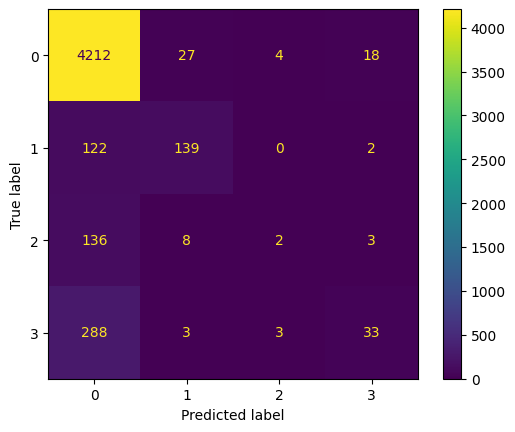

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

## Experiment 3.2: Investigating TFIDF

Regenerating the dataset

In [ ]:
# Regenerating Datasets

dataset = load_dataset("surrey-nlp/PLOD-CW")

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

np.random.seed(500) # For reproducibility

# Flattening Inputs
flat_inputs_train = [item for sublist in train_dataset["tokens"] for item in sublist]
flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_inputs_test = [item for sublist in test_dataset["tokens"] for item in sublist]

# Flattening Labels
flat_labels_train = [item for sublist in train_dataset["ner_tags"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]
flat_labels_test = [item for sublist in test_dataset["ner_tags"] for item in sublist]

Again we convert our labels to numeric form

In [ ]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in flat_labels_train:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

testConvertedLabels = []
for sample in flat_labels_test:
    testConvertedLabels.append(label_encoding.get(sample))
print(len(testConvertedLabels))

40000
5000
5000


Loading in TFIDF, fitting the TFIDF model to our training data and then transforming validation data.

TFIDF is more crude as it uses inverse log unlike W2V or GLoVE.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(flat_inputs_train) # We fit TFIDF to trainInputs

valInputs = tfidf.transform(flat_inputs_val) # We then convert val inputs using the same trained tfidf
testInputs = tfidf.transform(flat_inputs_test)

print(trainInputs.shape)
print(valInputs.shape)
print(testInputs.shape)

(40000, 7869)
(5000, 7869)
(5000, 7869)


Training and predicting with the SVM

In [ ]:
svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4261
           1       0.85      0.39      0.54       263
           2       0.59      0.28      0.38       149
           3       0.49      0.25      0.33       327

    accuracy                           0.87      5000
   macro avg       0.71      0.47      0.54      5000
weighted avg       0.86      0.87      0.85      5000



Getting the Confusion Matrix

[[4147   15   23   76]
 [ 158  103    0    2]
 [  98    3   41    7]
 [ 240    0    5   82]]


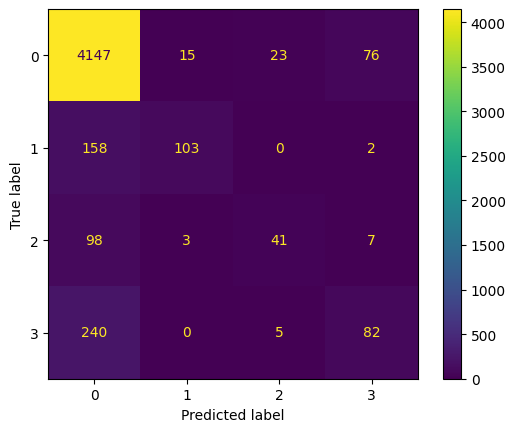

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

## Experiment 3.3: Investigating GLoVE

Regenerating the datasets

In [ ]:
# Regenerating Datasets

dataset = load_dataset("surrey-nlp/PLOD-CW")

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

np.random.seed(500)

# Flattening Inputs
flat_inputs_train = [item for sublist in train_dataset["tokens"] for item in sublist]
flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_inputs_test = [item for sublist in test_dataset["tokens"] for item in sublist]

# Flattening Labels
flat_labels_train = [item for sublist in train_dataset["ner_tags"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]
flat_labels_test = [item for sublist in test_dataset["ner_tags"] for item in sublist]

Again, converting the labels

In [ ]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in flat_labels_train:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

testConvertedLabels = []
for sample in flat_labels_test:
    testConvertedLabels.append(label_encoding.get(sample))
print(len(testConvertedLabels))

40000
5000
5000


Next we need to download the GLoVE model. For better comparision with W2V we will again use a 300 dimension set of weights

In [ ]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-300') # Dimension of 300

# Verifying the shape of an embedding input to be of dim 300
print(glove_model["hello"].shape) # (300,)

[==================================================] 100.0% 376.1/376.1MB downloaded
(300,)


We again need to create a function to embed our tokens and handle ones that are not in the vocab

In [ ]:
def gloveEmbedder(inputList):
  embeddings = []

  for token in inputList:
    if token in glove_model:
      embeddings.append(glove_model[token])
    else:
      embeddings.append(np.zeros(300,))

  return embeddings

In [ ]:
trainInputs = gloveEmbedder(flat_inputs_train)
valInputs = gloveEmbedder(flat_inputs_val)
testInputs = gloveEmbedder(flat_inputs_test)

Testing w/ SVM

In [ ]:
svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      4261
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00       149
           3       0.58      0.07      0.12       327

    accuracy                           0.85      5000
   macro avg       0.36      0.27      0.26      5000
weighted avg       0.77      0.85      0.79      5000



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion Matrix

[[4246    1    3   11]
 [ 263    0    0    0]
 [ 144    0    0    5]
 [ 305    0    0   22]]


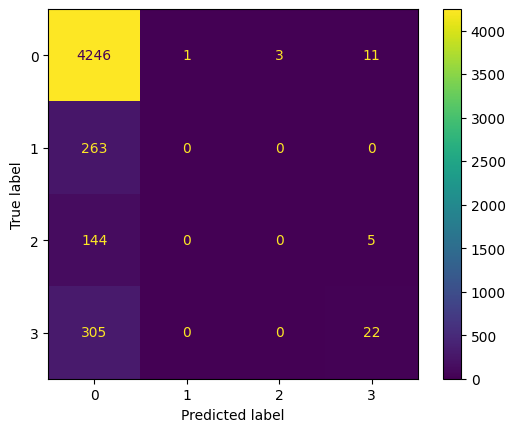

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

# Experiment 4: Investigating with different proportions of the dataset
In this series of experiments, we will investigate how the performance of an HMM model is affect when exposed to more data in terms of the full PLOD dataset, along with a smaller portion of it.

Most of the code is taken Experiment 2.1 with minor changes.

## Experiment 4.1: Testing HMM with the full PLOD dataset

Imports

In [16]:
%pip install datasets
import nltk
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset, load_metric

Loading the Dataset

In [17]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-Filtered")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Get the training data

In [18]:
# We grab the sentences in this format as it gives us an easier list format to work with
trainSentences = dataset["train"][:]["tokens"]
trainLabels = dataset["train"][:]["ner_tags"]

print(len(trainSentences))

print(trainSentences)
print(trainLabels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Getting set of tokens and labels

In [23]:
# We need the unique set of tokens
# We need the unique set of labels (pre-post conversion?)

symbolSet = set()
for tokenSet in trainSentences:
  for token in tokenSet:
    for char in token:
      symbolSet.add(char)

# Get the unique set of labels
entitySet = set()
for tagSet in trainLabels:
  for tag in tagSet:
    entitySet.add(tag)

Converting sets to lists

In [24]:
entitySet = list(entitySet) # Convert back to lists
print(entitySet)

symbolSet = list(symbolSet)
print(symbolSet)
print(len(symbolSet))

[0, 1, 3, 4]
['Ā', '™', 'f', '1', '⑰', 'к', '‒', '⑳', 'Ï', '〉', '8', 'Ο', '○', '▄', 'γ', 'Ѱ', '⑮', 'H', '!', 'ν', 'ҫ', 'n', 'а', 'ε', '≧', '℘', 'ç', 'ξ', 'ℝ', 'W', 'â', '\xad', 'φ', '—', 'Φ', 'ɳ', 'q', '<', '⑯', 'ý', 'ł', 's', 'ê', '6', '□', 't', '◇', "'", '˗', '⑫', '4', '"', 'z', '⩾', 'm', 'Á', 'ǁ', '★', 'Ä', 'ʎ', 'μ', 'ɑ', '¼', 'Σ', '■', '⑨', '∕', '・', 'ú', '�', 'ü', 'ӧ', '≥', '♦', 'χ', 'υ', 'É', 'U', 'O', '∶', 'ρ', 'I', 'Å', '∼', 'õ', 'Π', 'ẞ', '②', '∙', 'ƞ', '↑', 'ƒ', 'ˉ', 'ʹ', 'қ', '∇', '#', '✧', '®', 'æ', '0', 'π', '¶', '∅', '◊', '⑥', '÷', '⑦', '⟞', 'd', 'À', '∧', '’', 'ﬀ', '∏', '⇔', 'ø', 'ö', 'w', 'S', '»', '⋆', 'é', 'B', 'ß', 'ᵒ', 'ë', 'k', 'l', 'Î', 'ϖ', 'Ü', 'δ', 'V', '⊥', 'ˊ', 'ẟ', '7', '+', '△', 'ã', 'ψ', ')', 'i', '∈', '˂', '˜', '↔', '|', '←', 'E', '∂', '¤', '−', '²', '•', 'Θ', ',', '¯', 'c', 'b', '×', '$', 'ó', 'ϑ', 'ϒ', '∩', 'à', 'e', 'T', 'M', '∆', 'ζ', '~', 'П', '―', 'A', '⟩', 'Q', '〖', 'Ɛ', '∑', '∪', '\\', 'u', 'Z', '?', 'Y', '⌋', '€', '‑', '̂', '±', '>', '☆', ';', 'µ

Restructuring dataset to be in pairs

In [26]:
# Double list comprehension
trainCombinedOld = [[(token, label) for token, label in zip(tokenSet, labelSet)] for tokenSet, labelSet in zip(trainSentences, trainLabels)]

# Single list comprehension
trainCombined = []
for tokens, labels in zip(trainSentences, trainLabels):
    sequence = [(token, label) for token, label in zip(tokens, labels)]
    trainCombined.append(sequence)

print(trainCombined[0])
print(trainCombinedOld[0])

# Note that it is very very very important that this is done correctly or the HMM will have errors when evaluating!

[('Alternatively', 0), (',', 0), ('fibroblasts', 0), ('were', 0), ('plated', 0), ('sparsely', 0), ('so', 0), ('that', 0), ('they', 0), ('did', 0), ('not', 0), ('touch', 0), ('each', 0), ('other', 0), ('and', 0), ('induced', 0), ('into', 0), ('quiescence', 0), ('by', 0), ('serum', 0), ('starvation', 0), ('and', 0), ('monitored', 0), ('after', 0), ('4', 0), ('d', 0), ('(', 0), ('serum', 3), ('-', 4), ('starved', 4), ('for', 4), ('4', 4), ('d', 4), ('[', 0), ('SS4', 1), (']', 0), (')', 0), ('or', 0), ('7', 0), ('d', 0), ('(', 0), ('serum', 3), ('-', 4), ('starved', 4), ('for', 4), ('7', 4), ('d', 4), ('[', 0), ('SS7', 1), (']', 0), (')', 0), ('.', 0)]
[('Alternatively', 0), (',', 0), ('fibroblasts', 0), ('were', 0), ('plated', 0), ('sparsely', 0), ('so', 0), ('that', 0), ('they', 0), ('did', 0), ('not', 0), ('touch', 0), ('each', 0), ('other', 0), ('and', 0), ('induced', 0), ('into', 0), ('quiescence', 0), ('by', 0), ('serum', 0), ('starvation', 0), ('and', 0), ('monitored', 0), ('after',

Setting up and training HMM

In [27]:
trainerSetup = nltk.tag.hmm.HiddenMarkovModelTrainer(states = entitySet, symbols = symbolSet)

model = trainerSetup.train_supervised(trainCombined)

Predicting with HMM

In [28]:
import numpy as np

val_sentences = dataset["validation"][:]["tokens"] # Fetch from our validation set

# Getting the flattened tags for validation set
flatValLabels = [item for sublist in val_dataset["ner_tags"] for item in sublist]

# We need to individually go through each token in our dataset,
# evaluate on them using the HMM, then we extract the tag that comes out from the model
predicted = []
for sentence in val_sentences:
    val_result = model.tag(sentence)
    out_tags = []
    for word, tag in val_result:
        out_tags.append(tag)
    predicted.append(out_tags)

/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Fetching just the predicted tags

In [31]:
predTags = [tag for tagList in predicted for tag in tagList]

print(len(predTags))

print(set(predTags)) # Make sure that all tags exist

1129081
{0, 1, 3, 4}


In [34]:
val_dataset = dataset["validation"]

flatValLabels = [item for sublist in val_dataset["ner_tags"] for item in sublist]

print(len(flatValLabels))

1129081


Classification Report

In [35]:
from sklearn.metrics import classification_report

print(classification_report(flatValLabels, predTags))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    936270
           1       0.87      0.68      0.77     66204
           3       0.62      0.52      0.57     39415
           4       0.68      0.58      0.63     87192

    accuracy                           0.90   1129081
   macro avg       0.78      0.68      0.72   1129081
weighted avg       0.89      0.90      0.89   1129081



Confusion Matrix

[[896790   5944  10705  22831]
 [ 20711  45093    139    261]
 [ 17667    316  20416   1016]
 [ 34759    227   1476  50730]]


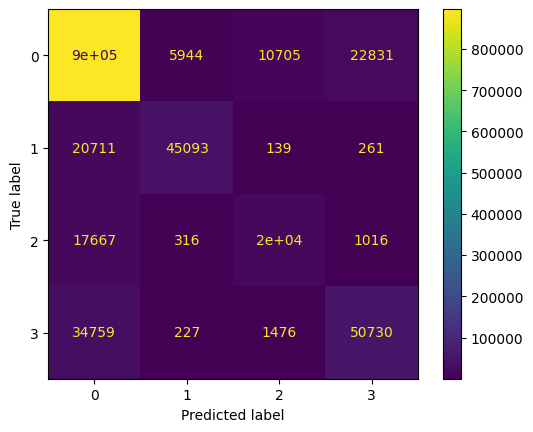

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(flatValLabels, predTags)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

## Experiment 4.2: Testing HMM with 60% of the full dataset

Loading imports

In [37]:
%pip install datasets
import nltk
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset, load_metric

Loading dataset

In [38]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-Filtered")

Setting up the datasets we want to use

In [39]:
train_dataset = dataset["train"] # Remember this is a dictionary
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

Selecting a random 60% of the dataset to be used as our training dataset, this allows for each token to have a fair chance at being selected. No bias

In [40]:
train_dataset = dataset["train"].train_test_split(train_size=0.6, shuffle=True)

Fetching sentences and labels

In [41]:
trainSentences = train_dataset["train"][:]["tokens"]
trainLabels = train_dataset["train"][:]["ner_tags"]

print(len(trainSentences))

print(trainSentences)
print(trainLabels)

67591


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Getting unique set of states and symbols

In [42]:
# We need the unique set of tokens
# We need the unique set of labels (pre-post conversion?)

symbolSet = set()
for tokenSet in trainSentences:
  for token in tokenSet:
    for char in token:
      symbolSet.add(char)

# Get the unique set of labels
entitySet = set()
for tagSet in trainLabels:
  for tag in tagSet:
    entitySet.add(tag)

Converting to list

In [43]:
entitySet = list(entitySet) # Convert back to lists
print(entitySet)

symbolSet = list(symbolSet)
print(symbolSet)
print(len(symbolSet))

[0, 1, 3, 4]
['Ā', '™', 'f', '1', '⑰', 'к', '‒', '⑳', 'Ï', '〉', '8', 'Ο', '○', '▄', 'γ', '⑮', 'H', '!', 'ν', 'ҫ', 'n', 'ε', '≧', '℘', 'ç', 'ξ', 'ℝ', 'W', 'â', 'φ', '\xad', '—', 'Φ', '<', 'q', '⑯', 'ł', 's', 'ê', '6', '□', 't', '˗', "'", '◇', '⑫', '4', '"', 'z', '⩾', 'm', 'Á', 'ǁ', 'ʎ', 'μ', 'ɑ', 'Σ', '■', '⑨', '∕', 'ú', '�', 'ü', 'ӧ', '≥', '♦', 'χ', 'υ', 'É', 'U', 'O', '∶', 'ρ', 'I', 'Å', '∼', 'õ', '②', 'ẞ', '∙', 'ƞ', '↑', 'ƒ', 'ˉ', 'ʹ', '#', '✧', '®', 'æ', '0', 'π', '¶', '◊', '⑥', '÷', '⑦', '⟞', 'd', 'À', '’', 'ﬀ', '⇔', 'ø', 'ö', 'w', 'S', '»', '⋆', 'é', 'B', 'ß', 'ᵒ', 'ë', 'k', 'l', 'Î', 'ϖ', 'Ü', 'δ', 'V', '⊥', 'ˊ', 'ẟ', '7', '+', '△', 'ã', 'ψ', ')', 'i', '∈', '˜', '↔', '|', 'E', '∂', '¤', '−', '²', '•', 'Θ', ',', '¯', 'c', 'b', '×', '$', 'ó', 'ϑ', 'ϒ', '∩', 'à', 'e', 'T', 'M', '∆', 'ζ', '~', '―', 'A', 'Q', '〖', '∑', '\\', 'u', 'Z', '?', 'Y', '€', '‑', '̂', '±', '>', '☆', ';', 'µ', '*', '⑱', '（', '°', '″', '▷', '=', '”', 'N', 'Ӓ', ':', '⋅', 'Ś', 'a', '⑧', '▪', '–', '〗', '√', 'ò', '3

Restructuring dataset

In [45]:
# Double list comprehension
trainCombinedOld = [[(token, label) for token, label in zip(tokenSet, labelSet)] for tokenSet, labelSet in zip(trainSentences, trainLabels)]

# Single list comprehension
trainCombined = []
for tokens, labels in zip(trainSentences, trainLabels):
    sequence = [(token, label) for token, label in zip(tokens, labels)]
    trainCombined.append(sequence)

print(trainCombined[0])
print(trainCombinedOld[0])

# Note that it is very very very important that this is done correctly or the HMM will have errors when evaluating!

[('LPal', 1), (',', 0), ('lateral', 3), ('pallium', 4), (';', 0), ('MLR', 1), (',', 0), ('mesencephalic', 3), ('locomotor', 4), ('region', 4), (';', 0), ('OB', 1), (',', 0), ('olfactory', 3), ('bulb', 4), (';', 0), ('PT', 1), (',', 0), ('posterior', 3), ('tuberculum', 4), ('.', 0)]
[('LPal', 1), (',', 0), ('lateral', 3), ('pallium', 4), (';', 0), ('MLR', 1), (',', 0), ('mesencephalic', 3), ('locomotor', 4), ('region', 4), (';', 0), ('OB', 1), (',', 0), ('olfactory', 3), ('bulb', 4), (';', 0), ('PT', 1), (',', 0), ('posterior', 3), ('tuberculum', 4), ('.', 0)]


Training HMM

In [46]:
trainerSetup = nltk.tag.hmm.HiddenMarkovModelTrainer(states = entitySet, symbols = symbolSet)

model = trainerSetup.train_supervised(trainCombined)

Predicting with HMM

In [47]:
import numpy as np

val_sentences = dataset["validation"][:]["tokens"] # Fetch from our validation set

# Getting the flattened tags for validation set
flatValLabels = [item for sublist in val_dataset["ner_tags"] for item in sublist]

# We need to individually go through each token in our dataset,
# evaluate on them using the HMM, then we extract the tag that comes out from the model
predicted = []
for sentence in val_sentences:
    val_result = model.tag(sentence)
    out_tags = []
    for word, tag in val_result:
        out_tags.append(tag)
    predicted.append(out_tags)

/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Getting just the predictions in the form of a 1D array

In [48]:
predTags = [tag for tagList in predicted for tag in tagList]

print(predTags)

print(len(predTags))

print(set(predTags)) # Make sure that all tags exist

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [49]:
print(len(flatValLabels))

1129081


Classification Report

In [50]:
from sklearn.metrics import classification_report

print(classification_report(flatValLabels, predTags))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    936270
           1       0.87      0.62      0.72     66204
           3       0.62      0.48      0.54     39415
           4       0.68      0.53      0.60     87192

    accuracy                           0.89   1129081
   macro avg       0.77      0.65      0.70   1129081
weighted avg       0.88      0.89      0.89   1129081



Confusion Matrix

[[899997   5454   9930  20889]
 [ 24836  41030    116    222]
 [ 19235    280  18944    956]
 [ 39000    224   1372  46596]]


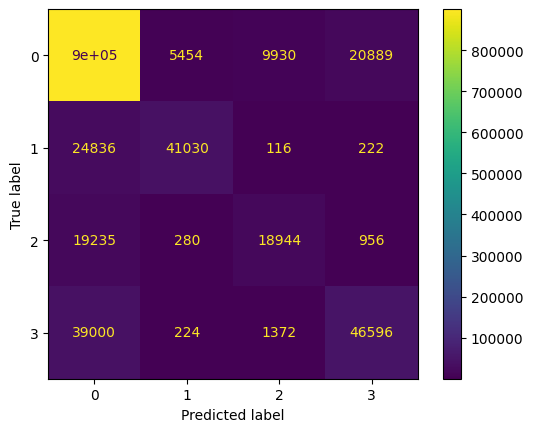

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(flatValLabels, predTags)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()